In [15]:
# Libraries
import pypdb       # For searching and downloading PDB files

import datetime     # for organizing file output
now = datetime.datetime.now()

import Bio      # Bio for downloading PDBs, printing protein lengths in residues
from Bio.PDB import PDBList
from Bio.PDB import PDBParser

import numpy as np
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [16]:
# query = "Q96RI1" # Farnesoid X Receptor (Homo sapiens)
# query = "P62937" # Cyclophilin A (Homo sapiens)

query = input("Supply a query (term, accession number, etc.) :")

# Tag the time right when the query is entered
def now_dir_ts():
    now_ts = str(now.year)+"_"+str(now.month)+"_"+str(now.day)+"_"+str(now.hour)+"_"+str(now.minute)+"_"+str(now.second)
    return now_ts

now = now_dir_ts()

PDB_dl_dir = "sure_data/"+input("Please enter a sub-directory of sure_data/:")+"/dataset_"+now

# PDB_dl_dir = input("Supply a directory path to download PDB's to:")
# PDB_dl_dir = "/Users/jacobnorth/Box/extracurriculars/research/SURE_S2020_fileshare/sure_data/cypA/Users/jacobnorth/Box/extracurriculars/research/SURE_S2020_fileshare/sure_data/"

# analy_dir = ''

print(PDB_dl_dir)

sure_data/fxr/dataset_2020_8_5_15_5_0


Search for and add PDBs to the list if you don't have them

In [17]:
# Using pyPDB
search_dict = pypdb.make_query(query)     # create a dictionary containing search information
found = pypdb.do_search(search_dict)      # create a list of these PDBs by searching RCSB

# create a list with the information and the metadata
metadata = []
info = []

for proteins in found:  # for items in # for the items in the list,
    metadata.append(pypdb.describe_pdb(proteins))  # append the dictionary from the query onto the end of the list
    #info.append(pypdb.get_all_info(proteins))    # do the same for the info list

In [18]:
# print(pypdb.get_all_info('1aki'))

In [19]:
# Save the metadata list as a CSV file
df = pd.DataFrame(metadata) # convert to a Pandas DF
df.to_csv('metadata_'+now+'.csv')      # save as a CSV file

Download the collected PDB ID's

In [20]:
parser = PDBParser()       # create a parser
pdbs = list()
pdbl = PDBList()

# Download all PDB structures in the previous list if they aren't there
for id in found:
    pdbl.retrieve_pdb_file(pdb_code=id, file_format='pdb', pdir=PDB_dl_dir)   # Retrieve in PDB format, put in directory 'PDB'

# Finished, print "Downloading ... finished!"
print('\n#############~DOWNLOADING COMPLETE~#############\n')


#############~DOWNLOADING COMPLETE~#############



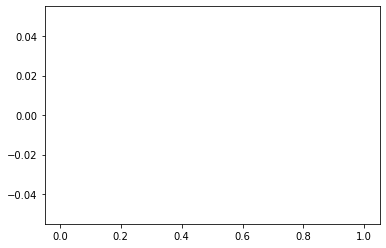

In [21]:
res_counts = list()

for pdb in pdbs:
    count = 0
    for residue in pdb.get_residues():
        count+=1
    print("PDB:", pdb, "has", count, "residues.")
    res_counts.append(count)

plt.hist(res_counts, facecolor='blue', alpha=0.5)
plt.show()

Extract ligands from the PDBs and create files for these ligands!

In [22]:
## CREDIT: Pat Walters

# These functions allow the extraction of a PDB ligand from a PDB file

import sys
from prody import *
from rdkit import Chem
from rdkit.Chem import AllChem
from io import StringIO
import pypdb


def get_pdb_components(pdb_id):
    """
    Split a protein-ligand pdb into protein and ligand components
    :param pdb_id:
    :return:
    """
    pdb = parsePDB("sure_data/"+pdb_id)
    protein = pdb.select('protein')
    ligand = pdb.select('not protein and not water')
    return protein, ligand


def process_ligand_sdf(ligand, res_name):
    """
    Add bond orders to a pdb ligand
    1. Select the ligand component with name "res_name"
    2. Get the corresponding SMILES from pypdb
    3. Create a template molecule from the SMILES in step 2
    4. Write the PDB file to a stream
    5. Read the stream into an RDKit molecule
    6. Assign the bond orders from the template from step 3
    :param ligand: ligand as generated by prody
    :param res_name: residue name of ligand to extract
    :return: molecule with bond orders assigned
    """
    output = StringIO()
    sub_mol = ligand.select(f"resname {res_name}")
    chem_desc = pypdb.describe_chemical(f"{res_name}")
    sub_smiles = chem_desc["describeHet"]["ligandInfo"]["ligand"]["smiles"]
    template = AllChem.MolFromSmiles(sub_smiles)
    writePDBStream(output, sub_mol)
    pdb_string = output.getvalue()
    rd_mol = AllChem.MolFromPDBBlock(pdb_string)
    new_mol = AllChem.AssignBondOrdersFromTemplate(template, rd_mol)
    return new_mol


def write_pdb(protein, pdb_name):
    """
    Write a prody protein to a pdb file
    :param protein: protein object from prody
    :param pdb_name: base name for the pdb file
    :return: None
    """
    output_pdb_name = f"{pdb_name}.pdb"
    writePDB(f"{output_pdb_name}", protein)
    print(f"wrote {output_pdb_name}")


def write_sdf(new_mol, pdb_name, res_name):
    """
    Write an RDKit molecule to an SD file
    :param new_mol:
    :param pdb_name:
    :param res_name:
    :return:
    """
    outfile_name = f"{pdb_name}_{res_name}_ligand.sdf"
    writer = Chem.SDWriter(f"{outfile_name}")
    writer.write(new_mol)
    print(f"wrote {outfile_name}")


In [23]:
for pdb in pdbs:
    protein, ligand = get_pdb_components(pdb_name)
    write_pdb(protein, pdb_name)        # write protein PDB
    write_pdb(ligand, res_name)

    res_name_list = list(set(ligand.getResnames()))
    for res in res_name_list:
        new_mol = process_ligand_sdf(ligand, res)

        write_sdf(new_mol, pdb_name, res)
        write_pdb()